In [22]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 1 - Constant power device

In [23]:
P=1
R=1

## Case 1

In [24]:
v = np.linspace(0,100, 100)
v_21 = (v + np.sqrt(v**2 - 4*R*P))/2

/var/folders/70/t8y6c9g973j5xg3yj6tb5_pc0000gn/T/ipykernel_76526/1019263006.py:2: RuntimeWarning: invalid value encountered in sqrt
  v_21 = (v + np.sqrt(v**2 - 4*R*P))/2


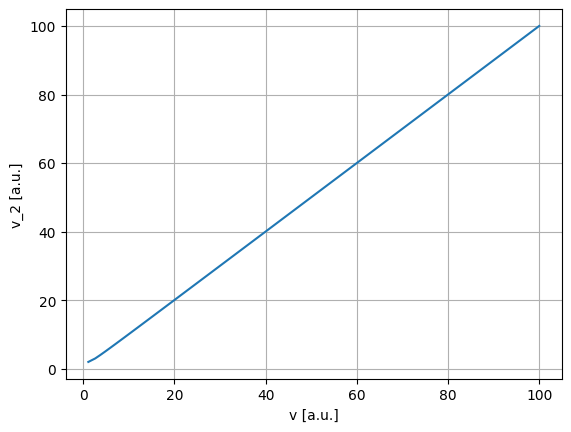

In [25]:
plt.plot(v_21,v)
plt.xlabel('v [a.u.]')
plt.ylabel('v_2 [a.u.]')
plt.grid()

## Case 2

In [26]:
v_22 = (v - np.sqrt(v**2 - 4*R*P))/2

/var/folders/70/t8y6c9g973j5xg3yj6tb5_pc0000gn/T/ipykernel_76526/3688844313.py:1: RuntimeWarning: invalid value encountered in sqrt
  v_22 = (v - np.sqrt(v**2 - 4*R*P))/2


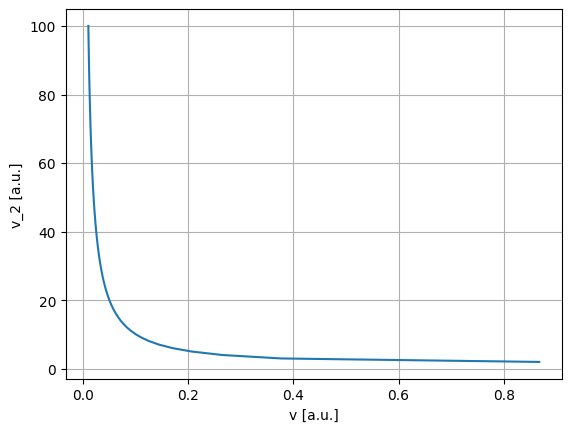

In [27]:
plt.plot(v_22,v)
plt.xlabel('v [a.u.]')
plt.ylabel('v_2 [a.u.]')
plt.grid()

# 4 - Time-of-Use Electricity Plans

## (a)

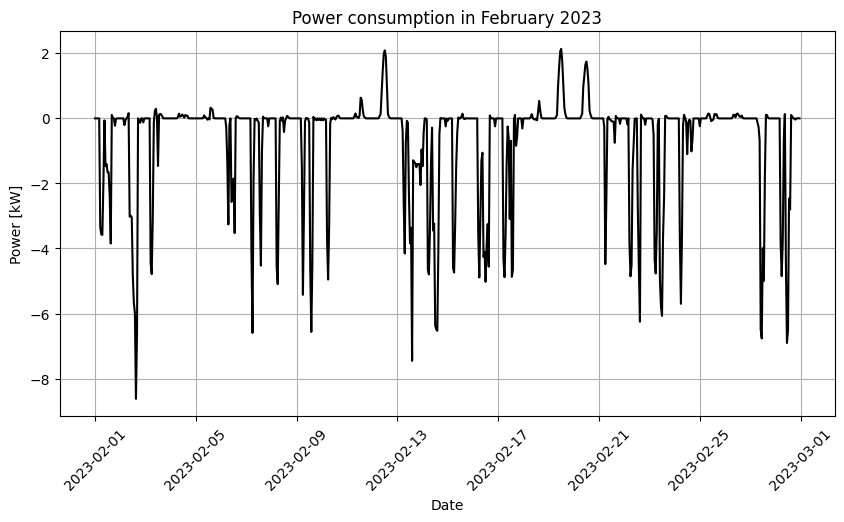

In [39]:
usage_data = pd.read_csv("data_2023_hourly.csv")
usage_data["Date & Time"] = pd.to_datetime(usage_data["Date & Time"])
feb_data = usage_data.loc[usage_data['Date & Time'].dt.month==2].copy(deep=True)
plt.figure(figsize=(10,5))
plt.plot(feb_data["Date & Time"], feb_data["Usage [kW]"],color='black')
plt.xticks(rotation=45)
plt.title("Power consumption in February 2023")
plt.xlabel("Date")
plt.ylabel("Power [kW]")
plt.grid()
plt.show()

## (b)

In [29]:
#Demand rate Winter ($/kW)- Secondary Voltage - $44.58  - Submitted March 28, 2024
def calculate_demand_rate(df, demand_rate = 44.58):
    demand_cost =demand_rate*abs(np.min(df["Usage [kW]"]))
    return demand_cost

#Energy rate Winter ($/kWh) - Secondary Voltage - part_peak: $0.19615 - off_peak: $0.19544 - Submitted March 28, 2024
def calculate_energy_rate(df, part_peak = 0.19615, off_peak = 0.19544):
    # Since our timestep is hourly, we can calculate the energy cost by multiplying the Usage [kW] by 1 (h) ang get the energy used in that hour [kWh].
    # Also, we can just use dt.hour (not need to account for minutes, e.g. 9:15am)
    df = df[df['Usage [kW]']<=0].copy(deep=True)
    df_weekend = df.loc[df['Date & Time'].dt.weekday>=5].copy(deep=True) # weekend (which is also off_peak)
    df_weekday = df.loc[df['Date & Time'].dt.weekday<5].copy(deep=True)
    df_weekday_part_peak = df_weekday.loc[(df_weekday['Date & Time'].dt.hour>=8.5) & (df_weekday['Date & Time'].dt.hour<=21.5)].copy(deep=True)
    df_weekday_off_peak = df_weekday.loc[(df_weekday['Date & Time'].dt.hour<=8.5) | (df_weekday['Date & Time'].dt.hour>=21.5)].copy(deep=True)
    ## Calculate energy_cost (part_peak)
    energy_cost_part_peak = part_peak*abs(df_weekday_part_peak["Usage [kW]"].sum())
    ## Calculate energy_cost (off_peak)
    energy_cost_off_peak = off_peak*abs(df_weekday_off_peak["Usage [kW]"].sum())
    energy_cost_off_peak = energy_cost_off_peak + off_peak*abs(df_weekend["Usage [kW]"].sum())
    total_energy_cost = energy_cost_part_peak + energy_cost_off_peak
    return total_energy_cost, energy_cost_part_peak, energy_cost_off_peak

def calculate_energy_sold(df, part_peak = 0.19615, off_peak = 0.19544, net_metering_policy = 0.20):
    # Since our timestep is hourly, we can calculate the energy cost by multiplying the Usage [kW] by 1 (h) ang get the energy used in that hour [kWh].
    # Also, we can just use dt.hour (not need to account for minutes, e.g. 9:15am)
    df = df[df['Usage [kW]']>=0].copy(deep=True)
    df_weekend = df.loc[df['Date & Time'].dt.weekday>=5].copy(deep=True) # weekend (which is also off_peak)
    df_weekday = df.loc[df['Date & Time'].dt.weekday<5].copy(deep=True)
    df_weekday_part_peak = df_weekday.loc[(df_weekday['Date & Time'].dt.hour>=8.5) & (df_weekday['Date & Time'].dt.hour<=21.5)].copy(deep=True)
    df_off_peak = df_weekday.loc[(df_weekday['Date & Time'].dt.hour<=8.5) | (df_weekday['Date & Time'].dt.hour>=21.5)].copy(deep=True)
    ## Calculate energy_cost (part_peak) - sold (notice >=0)
    energy_sold_part_peak = part_peak*net_metering_policy*(df_weekday_part_peak["Usage [kW]"].sum())
    ## Calculate energy_cost (off_peak) - sold (notice >=0)
    energy_sold_off_peak = off_peak*net_metering_policy*(df_off_peak["Usage [kW]"].sum())
    energy_sold_off_peak = energy_sold_off_peak + off_peak*net_metering_policy*(df_weekend["Usage [kW]"].sum())
    energy_sold_total = energy_sold_part_peak + energy_sold_off_peak
    return energy_sold_total


#### Sensors are not perfect - clean data

In [30]:
mask_low = usage_data["Usage [kW]"].abs()<=0.02
usage_data.loc[mask_low, "Usage [kW]"] = 0

In [31]:
jan_df = usage_data.loc[usage_data['Date & Time'].dt.month==1].copy(deep=True)
feb_df = usage_data.loc[usage_data['Date & Time'].dt.month==2].copy(deep=True)
mar_df = usage_data.loc[usage_data['Date & Time'].dt.month==3].copy(deep=True)

In [32]:
jan_demand_cost = calculate_demand_rate(jan_df)
jan_energy_cost,_,_ = calculate_energy_rate(jan_df)
feb_demand_cost = calculate_demand_rate(feb_df)
feb_energy_cost,_,_ = calculate_energy_rate(feb_df)
march_demand_cost = calculate_demand_rate(mar_df)
march_energy_cost,_,_ = calculate_energy_rate(mar_df)

In [33]:
data = {
    'Month': ['January', 'February', 'March'],
    'Demand Cost': [jan_demand_cost, feb_demand_cost, march_demand_cost],
    'Energy Cost': [jan_energy_cost, feb_energy_cost, march_energy_cost]
}
df_costs = pd.DataFrame(data)
df_costs['Total Cost'] = df_costs['Demand Cost'] + df_costs['Energy Cost']

In [41]:
df_costs

,Month,Demand Cost,Energy Cost,Total Cost,demand rate (%) of total cost
0,January,314.412883,86.223938,400.636821,78.478279
1,February,384.121935,96.636991,480.758927,79.899075
2,March,377.994613,115.987024,493.981637,76.519972


## (c)

In [35]:
df_costs['demand rate (%) of total cost'] = df_costs['Demand Cost']/df_costs['Total Cost']*100
df_costs[['Month', 'demand rate (%) of total cost']]

,Month,demand rate (%) of total cost
0,January,78.478279
1,February,79.899075
2,March,76.519972


## (d)

In [36]:
jan_energy_earned = calculate_energy_sold(jan_df)
feb_energy_earned = calculate_energy_sold(feb_df)
mar_energy_earned = calculate_energy_sold(mar_df)

In [46]:
data = {
    'Month': ['January', 'February', 'March'],
    'Revenue ($)': [jan_energy_earned, feb_energy_earned, mar_energy_earned],
}
df_revenue = pd.DataFrame(data)

In [47]:
df_revenue

,Month,Revenue ($)
0,January,0.826822
1,February,1.420289
2,March,5.203728
